In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch
import torch.nn as nn
from transformers import FNetForSequenceClassification




In [2]:
# Load dataset

dataset = load_dataset('xnli', 'en')
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')



Using the latest cached version of the dataset since xnli couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'en' at C:\Users\Me\.cache\huggingface\datasets\xnli\en\0.0.0\b8dd5d7af51114dbda02c0e3f6133f332186418e (last modified on Thu May 15 13:55:18 2025).


In [3]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")



In [4]:
# Tokenize the dataset (XNLI uses 'premise' and 'hypothesis')
def tokenize(batch):
    return tokenizer(batch["premise"], batch["hypothesis"], truncation=True, padding="max_length", max_length=256)

encoded = dataset.map(tokenize, batched=True)
encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])





Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

In [5]:
train_data = encoded["train"].shuffle(seed=42).select(range(10000))
test_data = encoded["test"].select(range(2000))



In [6]:
# Load teacher model (mBERT)
teacher_model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)
teacher_model.eval()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
from PM4DA2E import PM4DA2EModel

#PM4DA2E model
student_model = PM4DA2EModel.from_pretrained("PM4DA2E")




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Define distillation loss
class DistillationLoss(nn.Module):
    def __init__(self, temperature=2.0, alpha=0.5):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction="batchmean")
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        soft_teacher = torch.nn.functional.log_softmax(teacher_logits / self.temperature, dim=-1)
        soft_student = torch.nn.functional.softmax(student_logits / self.temperature, dim=-1)
        distill_loss = self.kl_div(soft_teacher, soft_student) * (self.temperature ** 2)
        student_loss = self.ce_loss(student_logits, labels)
        return self.alpha * student_loss + (1 - self.alpha) * distill_loss

# Custom Trainer for Distillation
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, distill_loss_fn, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        self.teacher.eval()
        self.distill_loss_fn = distill_loss_fn

def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
    labels = inputs.pop("labels")
    with torch.no_grad():
        teacher_outputs = self.teacher(**inputs)
    student_outputs = model(**inputs)
    loss = self.distill_loss_fn(student_outputs.logits, teacher_outputs.logits, labels)
    return (loss, student_outputs) if return_outputs else loss




In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./PM4DA2E-distilled",
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    num_train_epochs=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-7,
    logging_dir="./logs",
    report_to="none"
)

# Initialize Trainer
trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    distill_loss_fn=DistillationLoss(temperature=2.0, alpha=0.5),
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
)



c:\_SD_\A3\envs\paper2_v2\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Me\AppData\Local\Temp\ipykernel_8924\1847071156.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [ ]:
# Train the model
trainer.train()

Epoch 1/50
782/782 [==============================] - 8s 9ms/step - loss: 0.3666 - sparse_categorical_accuracy: 0.8336
Epoch 2/50
782/782 [==============================] - 7s 9ms/step - loss: 0.1566 - sparse_categorical_accuracy: 0.9405
Epoch 3/50
782/782 [==============================] - 7s 9ms/step - loss: 0.0660 - sparse_categorical_accuracy: 0.9764
Epoch 4/50
782/782 [==============================] - 7s 9ms/step - loss: 0.0290 - sparse_categorical_accuracy: 0.9902
Epoch 5/50
782/782 [==============================] - 7s 9ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9942
Epoch 6/50
782/782 [==============================] - 7s 9ms/step - loss: 0.0147 - sparse_categorical_accuracy: 0.9946
Epoch 7/50
782/782 [==============================] - 7s 9ms/step - loss: 0.0220 - sparse_categorical_accuracy: 0.9926
Epoch 8/50
782/782 [==============================] - 7s 9ms/step - loss: 0.0095 - sparse_categorical_accuracy: 0.9967
Epoch 9/50
782/782 [============================

[2.080871343612671, 0.8537999987602234]

In [ ]:
# Train and evaluate teacher on data.
history_val = teacher_model.fit(x_val, y_val, epochs=epochs)
teacher_model.evaluate(x_val, y_val)

Epoch 1/50
782/782 [==============================] - 8s 9ms/step - loss: 0.3666 - sparse_categorical_accuracy: 0.8336
Epoch 2/50
782/782 [==============================] - 7s 9ms/step - loss: 0.1566 - sparse_categorical_accuracy: 0.9405
Epoch 3/50
782/782 [==============================] - 7s 9ms/step - loss: 0.0660 - sparse_categorical_accuracy: 0.9764
Epoch 4/50
782/782 [==============================] - 7s 9ms/step - loss: 0.0290 - sparse_categorical_accuracy: 0.9902
Epoch 5/50
782/782 [==============================] - 7s 9ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9942
Epoch 6/50
782/782 [==============================] - 7s 9ms/step - loss: 0.0147 - sparse_categorical_accuracy: 0.9946
Epoch 7/50
782/782 [==============================] - 7s 9ms/step - loss: 0.0220 - sparse_categorical_accuracy: 0.9926
Epoch 8/50
782/782 [==============================] - 7s 9ms/step - loss: 0.0095 - sparse_categorical_accuracy: 0.9967
Epoch 9/50
782/782 [============================

[2.080871343612671, 0.8537999987602234]

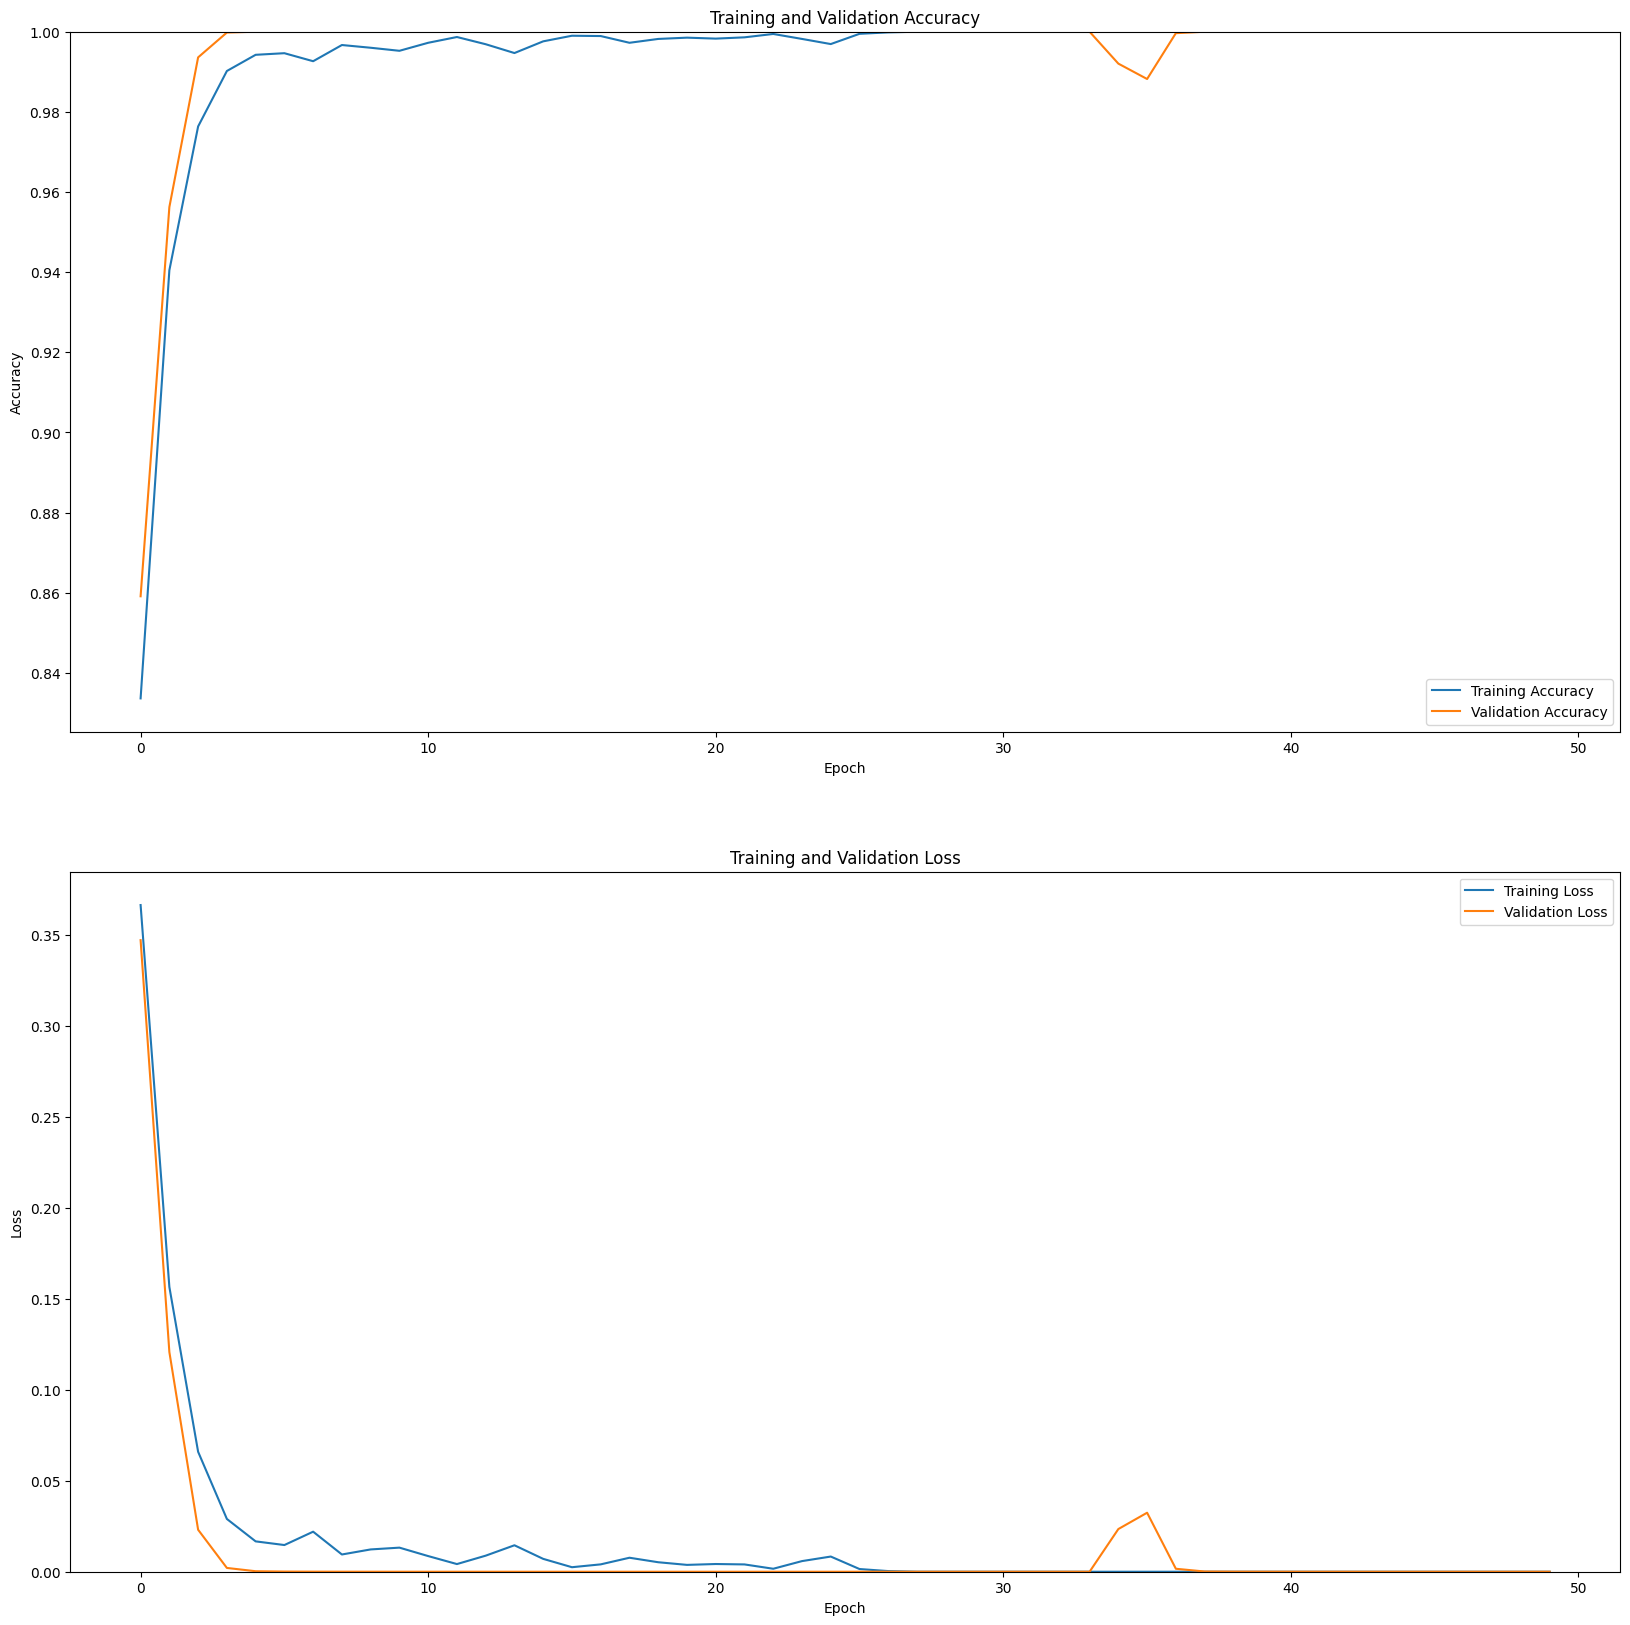

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
acc = history_train.history['sparse_categorical_accuracy']
val_acc = history_val.history['sparse_categorical_accuracy']

loss = history_train.history['loss']
val_loss = history_val.history['loss']

plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
#fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.show()

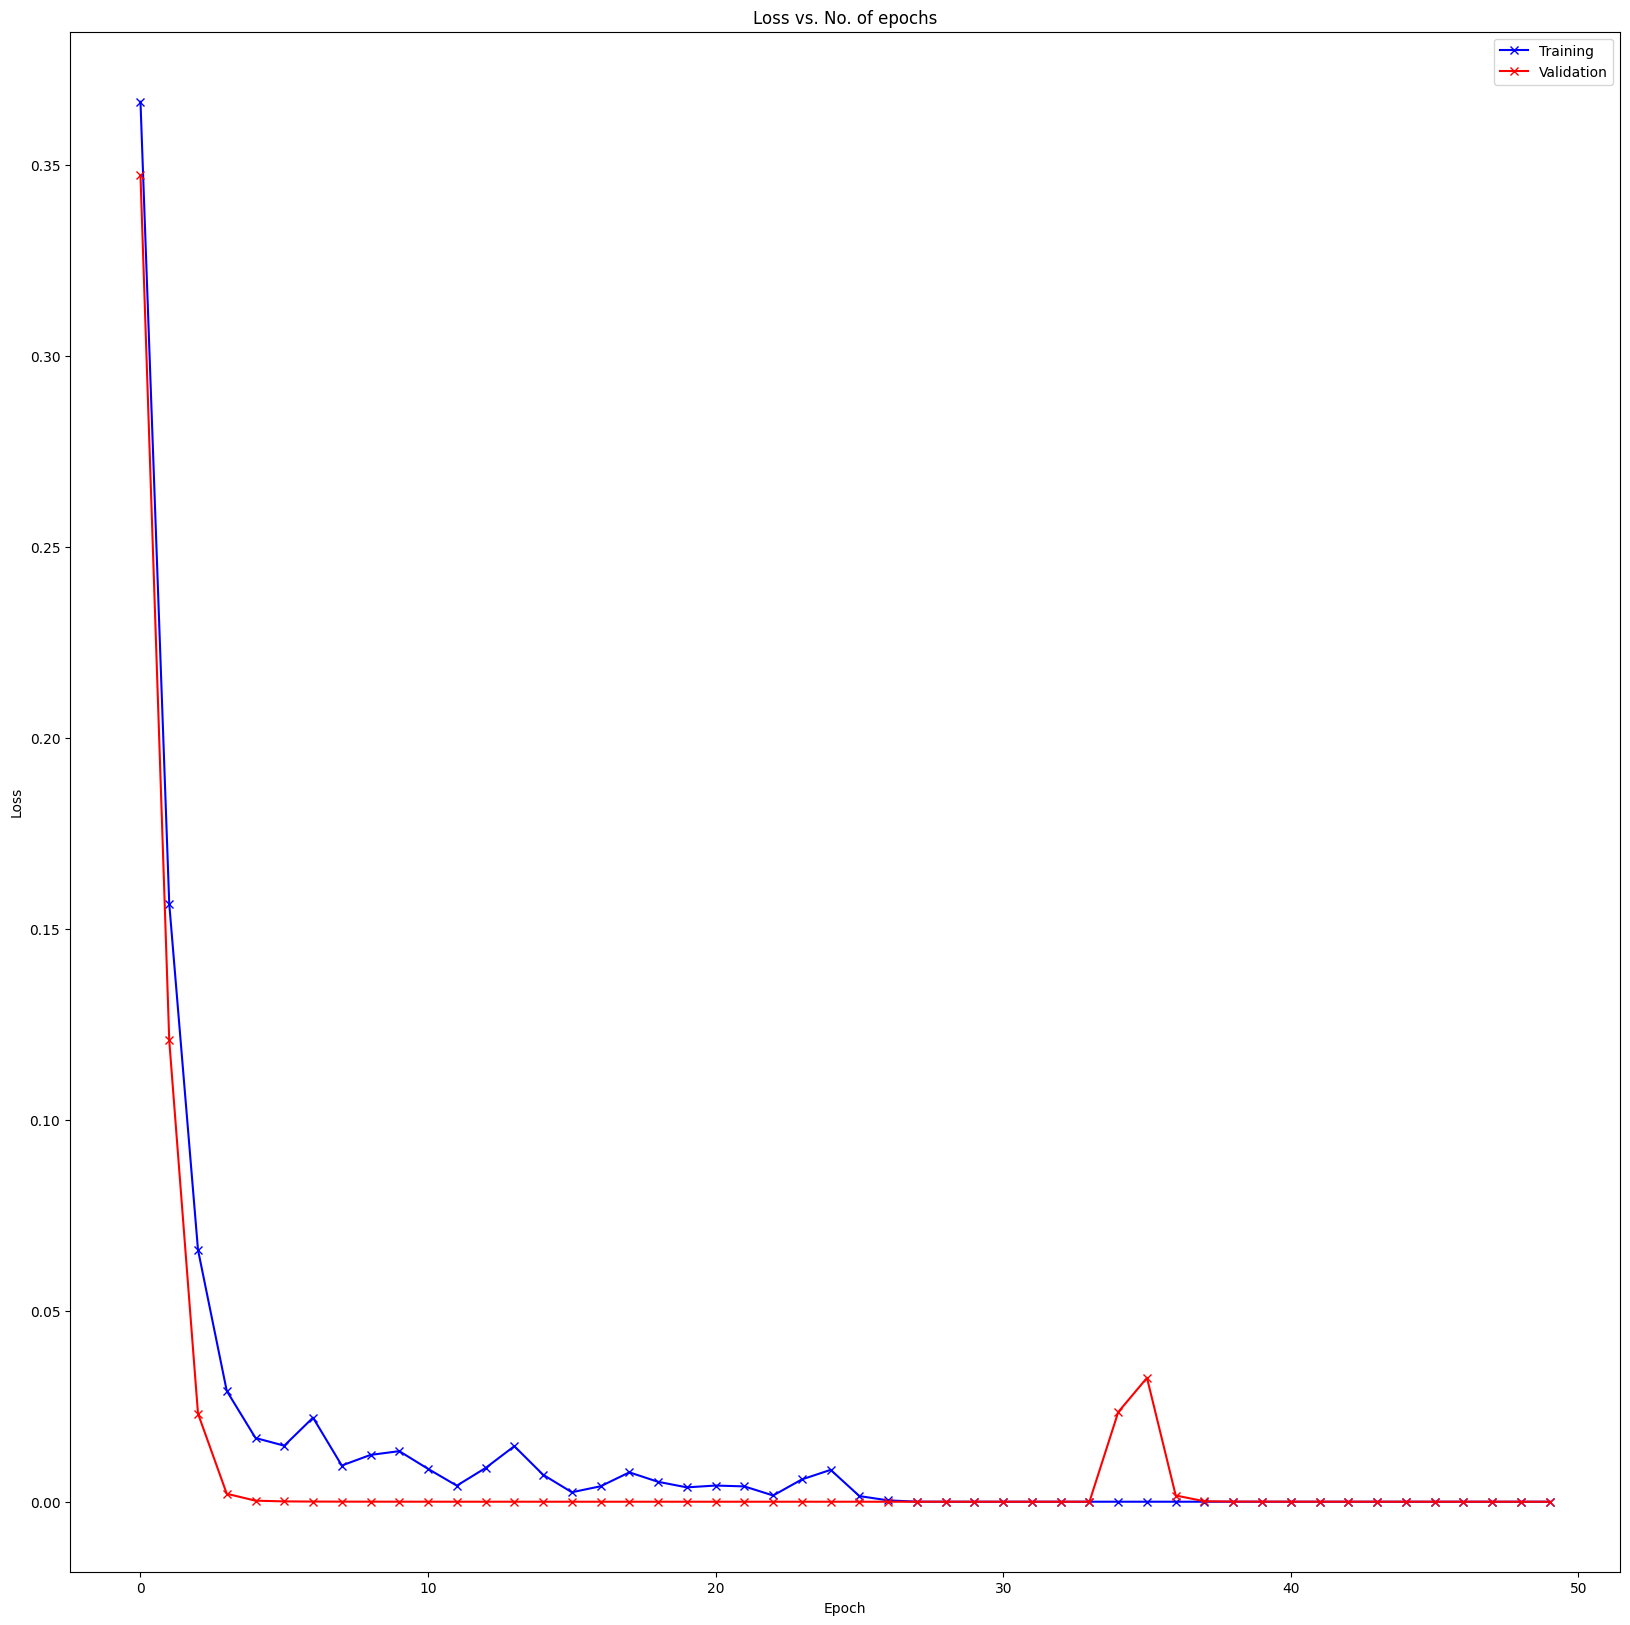

In [ ]:
def plot_losses(history_train, history_val):
    train_losses = [x for x in history_train.history['loss']]
    val_losses = [x for x in history_val.history['loss']]
    plt.figure(figsize=(20, 20))
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history_train, history_val)

In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
history_train = distiller.fit(x_train, y_train, epochs=epochs)

# Evaluate student on test dataset
distiller.evaluate(x_val, y_val)

Epoch 1/50
782/782 [==============================] - 26s 30ms/step - sparse_categorical_accuracy: 0.9315 - student_loss: 0.2113 - distillation_loss: 0.0185
Epoch 2/50
782/782 [==============================] - 24s 30ms/step - sparse_categorical_accuracy: 0.9894 - student_loss: 0.1045 - distillation_loss: 0.0096
Epoch 3/50
782/782 [==============================] - 24s 30ms/step - sparse_categorical_accuracy: 0.9992 - student_loss: 0.0793 - distillation_loss: 0.0096
Epoch 4/50
782/782 [==============================] - 23s 30ms/step - sparse_categorical_accuracy: 1.0000 - student_loss: 0.0702 - distillation_loss: 0.0095
Epoch 5/50
782/782 [==============================] - 23s 30ms/step - sparse_categorical_accuracy: 1.0000 - student_loss: 0.0676 - distillation_loss: 0.0095
Epoch 6/50
782/782 [==============================] - 23s 30ms/step - sparse_categorical_accuracy: 1.0000 - student_loss: 0.0676 - distillation_loss: 0.0094
Epoch 7/50
782/782 [==============================] - 23s 

[0.8808799982070923, 0.49796465039253235]

In [ ]:
# Train and evaluate teacher on data.
history_val = distiller.fit(x_val, y_val, epochs=epochs)
distiller.evaluate(x_val, y_val)

Epoch 1/50
782/782 [==============================] - 24s 30ms/step - sparse_categorical_accuracy: 0.9256 - student_loss: 0.2192 - distillation_loss: 0.0067
Epoch 2/50
782/782 [==============================] - 24s 30ms/step - sparse_categorical_accuracy: 0.9894 - student_loss: 0.0919 - distillation_loss: 0.0090
Epoch 3/50
782/782 [==============================] - 23s 30ms/step - sparse_categorical_accuracy: 0.9977 - student_loss: 0.0712 - distillation_loss: 0.0093
Epoch 4/50
782/782 [==============================] - 24s 30ms/step - sparse_categorical_accuracy: 0.9993 - student_loss: 0.0665 - distillation_loss: 0.0093
Epoch 5/50
782/782 [==============================] - 24s 30ms/step - sparse_categorical_accuracy: 0.9996 - student_loss: 0.0654 - distillation_loss: 0.0093
Epoch 6/50
782/782 [==============================] - 23s 30ms/step - sparse_categorical_accuracy: 0.9994 - student_loss: 0.0659 - distillation_loss: 0.0093
Epoch 7/50
782/782 [==============================] - 23s 

[0.9998000264167786, 0.06351301819086075]

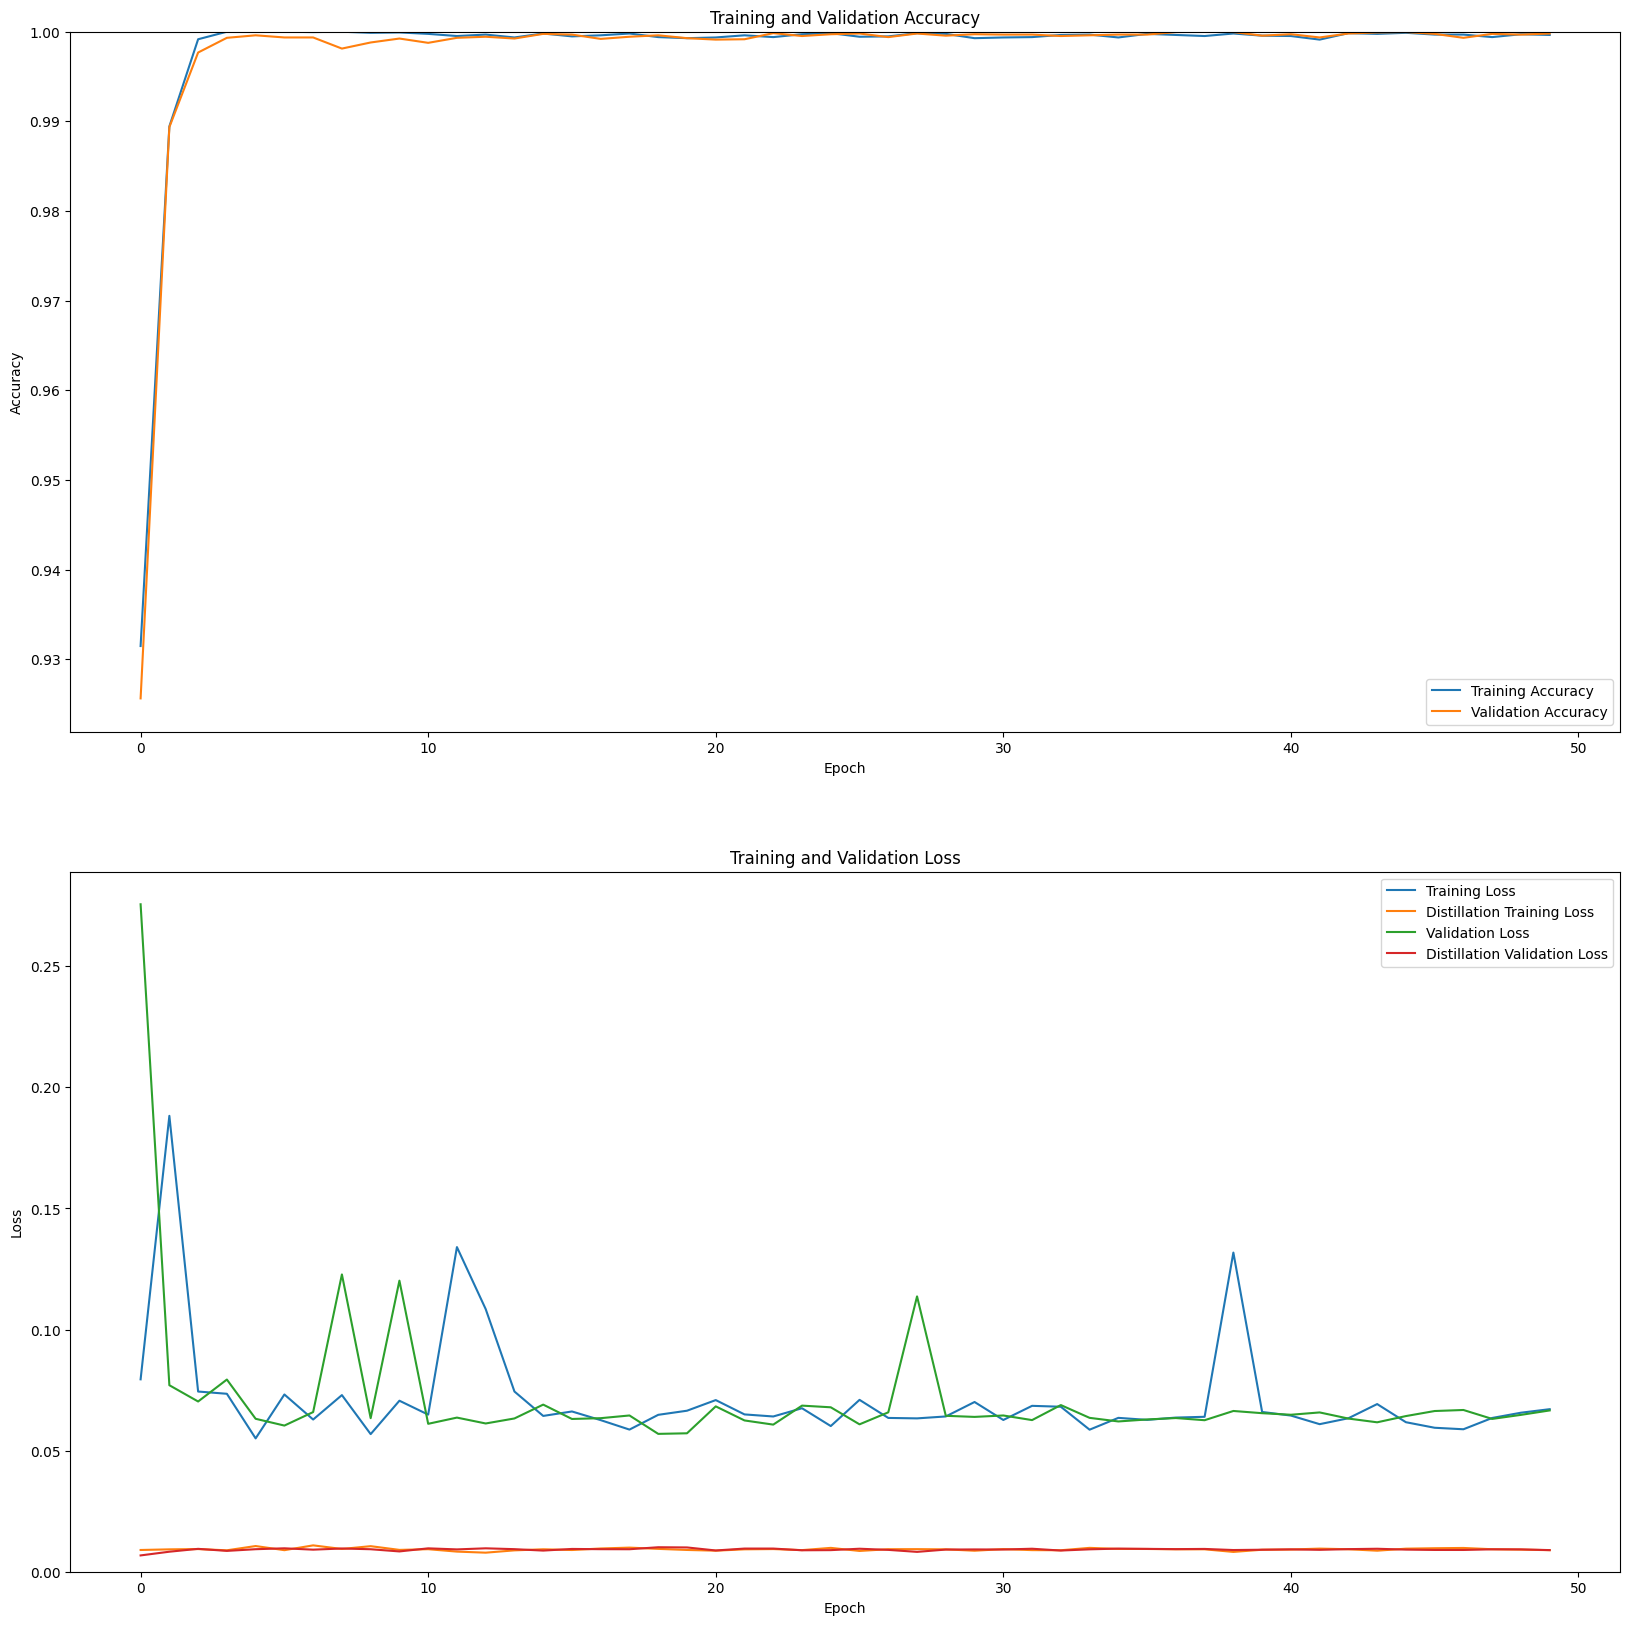

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
acc = history_train.history['sparse_categorical_accuracy']
val_acc = history_val.history['sparse_categorical_accuracy']

loss = history_train.history['student_loss']
val_loss = history_val.history['student_loss']

dloss = history_train.history['distillation_loss']
dval_loss = history_val.history['distillation_loss']


plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(dloss, label='Distillation Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot(dval_loss, label='Distillation Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
#fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.show()

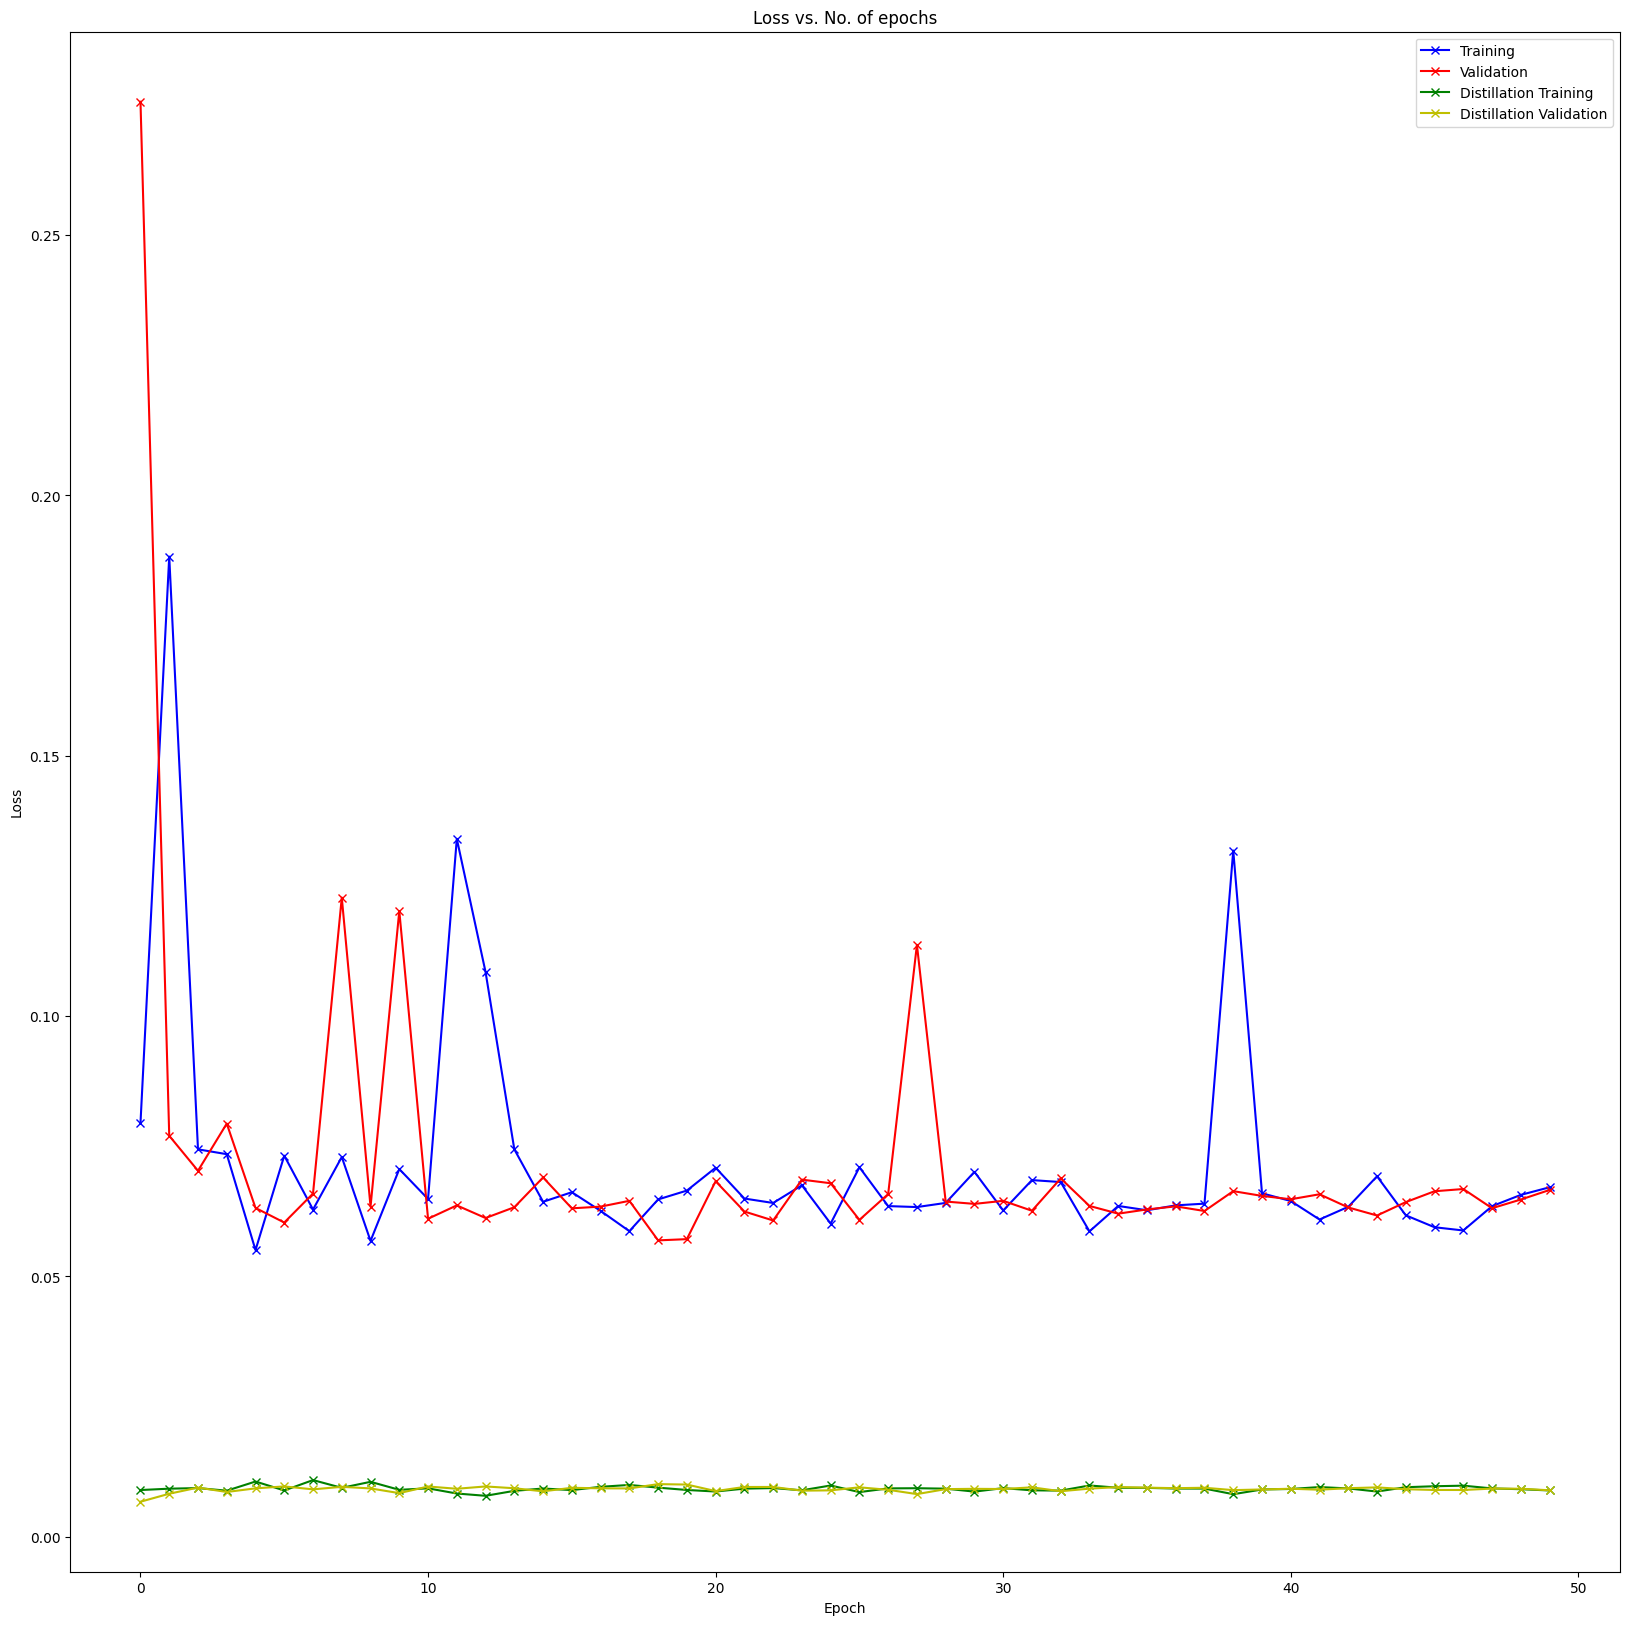

In [ ]:
def plot_losses(history_train, history_val):
    train_losses = [x for x in history_train.history['student_loss']]
    val_losses = [x for x in history_val.history['student_loss']]
    d_losses = [x for x in history_train.history['distillation_loss']]
    dval_losses = [x for x in history_val.history['distillation_loss']]
    plt.figure(figsize=(20, 20))
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.plot(d_losses, '-gx')
    plt.plot(dval_losses, '-yx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation','Distillation Training', 'Distillation Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history_train, history_val)